<a href="https://colab.research.google.com/github/shahedmomenzadeh/SAM_For_Electron_Microscopy_Dataset/blob/main/SAM_For_Electron_Microscopy_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to the dataset used in this demonstration: https://www.epfl.ch/labs/cvlab/data/data-em/

Source: EPFL


This code has been heavily adapted from this notebook but modified to work with a truly custom dataset where we have a bunch of images and binary masks. https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb

In [1]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-ggd6pg6q
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-ggd6pg6q
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=ae9ccbbfac9c3a55400d55883e070d61c843380bba76d0d78372add28c97430c
  Stored in directory: /tmp/pip-ephem-wheel-cache-um56ve7s/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment_anything
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 67,

**Patchify:**  


`from patchify import patchify` imports the patchify function from the patchify library.

What it does:

The patchify function divides a large image into smaller, overlapping or non-overlapping patches. This is useful for:

Processing large images that don't fit in memory.
Training deep learning models on image patches for better performance.
Analyzing specific regions of an image.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile # Used to handle tif images
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

**Downloading Dataset**

The dataset contains 4 sub-volumes:

training data and mask
testing data and mask

Link to the dataset:
https://www.epfl.ch/labs/cvlab/data/data-em/

In [3]:
# Uncomment this cell if the datasets aren't available

# !wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training.tif
# !wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/training_groundtruth.tif
# !wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/testing.tif
# !wget https://documents.epfl.ch/groups/c/cv/cvlab-unit/www/data/%20ElectronMicroscopy_Hippocampus/testing_groundtruth.tif

# # Moving dataset files to google drive so we don't need to download them again

# !cp /content/testing.tif /content/drive/MyDrive/Datasets/mito/
# !cp /content/training.tif /content/drive/MyDrive/Datasets/mito/
# !cp /content/testing_groundtruth.tif /content/drive/MyDrive/Datasets/mito/
# !cp /content/training_groundtruth.tif /content/drive/MyDrive/Datasets/mito/

In [4]:
# Load tiff stack images and masks

#165 large images as tiff image stack
large_images = tifffile.imread("/content/drive/MyDrive/Datasets/mito/training.tif")
large_masks = tifffile.imread("/content/drive/MyDrive/Datasets/mito/training_groundtruth.tif")

In [5]:
large_images[0].shape

# 165 images of size 768 * 1024

(768, 1024)

divide these large images into smaller patches for training. We can use patchify

In [6]:
# Desired patch size for smaller images and step size.
patch_size = 256
step = 256

In [7]:
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [8]:
images.shape

(1980, 256, 256)

In [9]:
print("Original images size : ", large_images.shape)
print("Original masks size : ", large_masks.shape)
print("Images size after patchify : ", images.shape)
print("Masks size after patchify : ", masks.shape)

Original images size :  (165, 768, 1024)
Original masks size :  (165, 768, 1024)
Images size after patchify :  (1980, 256, 256)
Masks size after patchify :  (1980, 256, 256)


Now, let us delete empty masks as they may cause issues later on during training. If a batch contains empty masks then the loss function will throw an error as it may not know how to handle empty tensors.

In [10]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (1642, 256, 256)
Mask shape: (1642, 256, 256)


We had 1980 images but some of them had zero mask, so we deleted them and now we have 1642 images

In [11]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

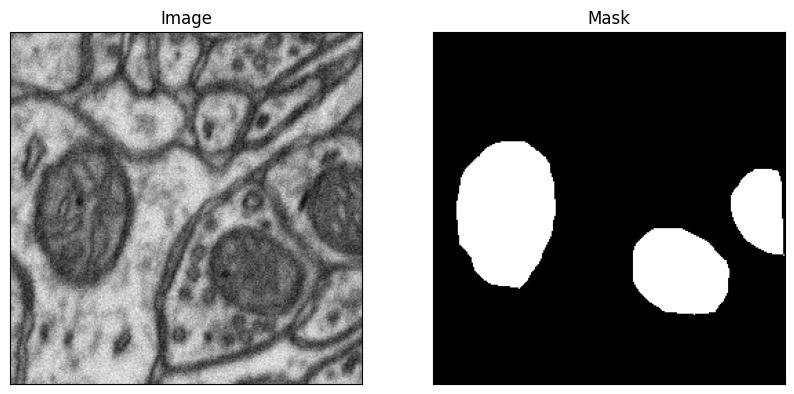

In [12]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

Get bounding boxes from masks
the code below is copies from:

https://github.com/NielsRogge/Transformers-Tutorials/blob/master/SAM/Fine_tune_SAM_(segment_anything)_on_a_custom_dataset.ipynb


In [13]:
#Get bounding boxes from mask.
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

Now that we have preprocessed the images and corrseponding masks, we can define our Pytorch dataset so we can use it in training.

In [14]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = np.repeat(image, 3, axis=-1)  # Repeat grayscale channel to create 3 channels
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [15]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [16]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [17]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [18]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [19]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [20]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [21]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 10

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

100%|██████████| 821/821 [13:29<00:00,  1.01it/s]


EPOCH: 0
Mean loss: 0.20090215525904107


100%|██████████| 821/821 [13:37<00:00,  1.00it/s]


EPOCH: 1
Mean loss: 0.13285374826548596


100%|██████████| 821/821 [13:37<00:00,  1.00it/s]


EPOCH: 2
Mean loss: 0.11840613817753005


100%|██████████| 821/821 [13:37<00:00,  1.00it/s]


EPOCH: 3
Mean loss: 0.11075348971722405


100%|██████████| 821/821 [13:38<00:00,  1.00it/s]


EPOCH: 4
Mean loss: 0.10354254574454803


100%|██████████| 821/821 [13:38<00:00,  1.00it/s]


EPOCH: 5
Mean loss: 0.09859633518566675


100%|██████████| 821/821 [13:38<00:00,  1.00it/s]


EPOCH: 6
Mean loss: 0.09725266793259532


100%|██████████| 821/821 [13:37<00:00,  1.00it/s]


EPOCH: 7
Mean loss: 0.0915041387457759


100%|██████████| 821/821 [13:37<00:00,  1.00it/s]


EPOCH: 8
Mean loss: 0.08846857093374419


100%|██████████| 821/821 [13:37<00:00,  1.00it/s]

EPOCH: 9
Mean loss: 0.08676314956977074


In [24]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/content/drive/MyDrive/models/mito_model_checkpoint.pth")

In [25]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [27]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/content/drive/MyDrive/models/mito_model_checkpoint.pth"))

<ipython-input-27-6bdfddc07ec4>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  my_mito_model.load_state_dict(torch.load("/content/drive/MyDrive/models/mito_model_checkpoin

<All keys matched successfully>

In [28]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

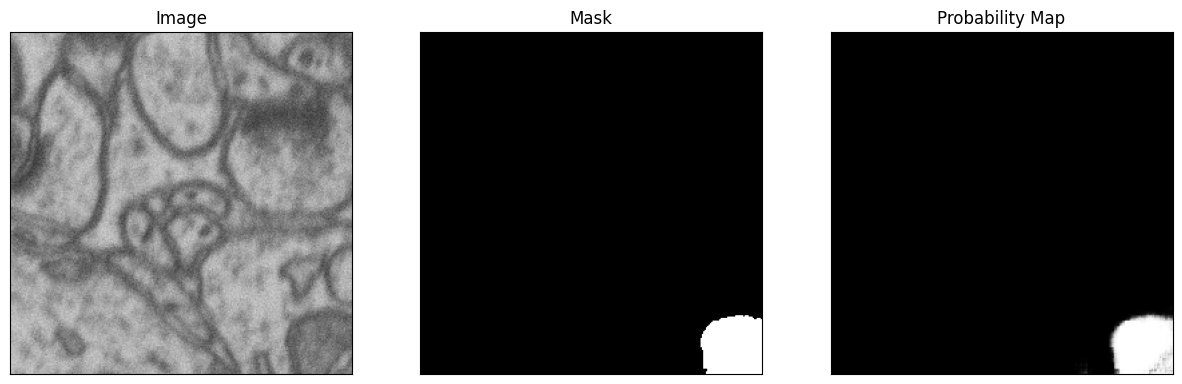

In [35]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]
test_image = np.expand_dims(test_image, axis=-1)  # Add channel dimension
test_image = np.repeat(test_image, 3, axis=-1)  # Repeat grayscale channel to create 3 channels

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob, cmap='gray')
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()